



#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 두가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 3단계 : 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇 2개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

### (1)라이브러리 설치

#### 1) gensim 설치

In [ ]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
!pip install gensim

#### 2) 형태소 분석을 위한 라이브러리

In [ ]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

In [ ]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
# !pip install mecab

### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import *

import tensorflow as tf
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from keras import Input, Model
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

* 형태소 분석을 위한 함수를 제공합니다.

In [15]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()

    return tokenizer

In [16]:
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)

    return tokenized_sent

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions
* Google Colab 환경에서 진행을 권장합니다.
    * 구글 드라이브 바로 밑에 project 폴더를 만들고,
    * 데이터 파일을 복사해 넣습니다.

#### 1) Google Colab 환경 구축

* 구글 드라이브 연결

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#ex : path = '/content/drive/MyDrive/project/'
path = '/content/drive/MyDrive/에이블/미니프로젝트6차_1,2일차/데이터/'

#### 2) 저장된 데이터 읽어오기
* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [61]:
train_df = joblib.load(path + 'train_set.pkl')
test_df = joblib.load(path + 'test_set.pkl')
clean_train_questions = joblib.load(path + 'clean_train_questions.pkl')
clean_test_questions = joblib.load(path + 'clean_test_questions.pkl')

In [62]:
train_df.shape, test_df.shape

((1192, 5), (106, 5))

In [63]:
clean_train_questions.shape, clean_test_questions.shape

((1192,), (106,))

## 2.챗봇1

* **상세요구사항**
    * Word2Vec을 활용한 LightGBM 모델링(intent 분류)
        * Word2Vec을 이용하여 임베딩벡터 생성하기
            * Word Embedding으로 문장벡터 구하기
        * 임베딩 벡터를 이용하여 ML기반 모델링 수행하기
            * LightGBM 권장(다른 알고리즘을 이용할수 있습니다.)
    * 챗봇 : 모델의 예측결과(intent)에 따라 답변하는 챗봇 만들기
        * 질문을 입력받아, 답변하는 함수 생성

### (1) Word2Vec을 이용하여 임베딩벡터 생성하기
* 'mecab' 형태소 분석기를 이용하여 문장을 tokenize
    * Word2Vec 모델을 만들기 위해서 입력 데이터는 리스트 형태여야 합니다.
    * 그래서 다시 리스트로 저장되도록 토크나이즈 해 봅시다.
* Word Embedding으로 문장벡터를 생성합니다.
    * 먼저 Word2Vec 모델을 만들고, train의 질문들을 문장벡터로 만듭시다.


#### 1) 'mecab' 형태소 분석기를 이용하여 문장을 tokenize

In [64]:
temp = list(train_df['Q'].apply(lambda x: tokenize('mecab', x).split(' ')).values)

In [65]:
temp[40:50]

[['오늘', '생각', '보다', '춥', '네'],
 ['추워', '죽', '을', '뻔', '했', '네'],
 ['추워', '죽', '겠', '다'],
 ['코', '막혀'],
 ['비', '맞', '아서', '옷', '젖', '었', '어'],
 ['옷', '이', '다', '젖', '었', '어'],
 ['열나', '고', '아파'],
 ['코', '맹맹'],
 ['동상', '걸릴', '뻔', '했', '어'],
 ['동상', '걸릴', '거', '같', '아', '.']]

#### 2) Word Embedding으로 문장벡터 구하기
* Word2Vec
    * 위에서 저장한 입력 데이터를 사용하여 Word2Vec 모델이 생성
    * 모델은 size(단어 벡터의 차원),
    * window(컨텍스트 창의 크기),
    * max_vocab_size(고려할 최대 어휘 크기),
    * min_count(포함할 단어의 최소 빈도)와 같은 특정 하이퍼파라미터로 훈련됩니다.
    * sg : 사용할 훈련 알고리즘 - 1은 skip-gram, 0은 CBOW )

In [66]:
wv_model = Word2Vec(sentences=temp,             # 학습할 문장
                    vector_size=100,            # 워드 임베딩 벡터의 크기
                    window=5,                   # 문맥 윈도우 크기
                    max_vocab_size=500,         # 학습에 사용할 최대 단어 수
                    min_count=5,                # 학습에 사용할 최소 단어 빈도 수
                    workers=4,                  # 학습을 위한 프로세스 수
                    epochs=10,                  # 학습 횟수
                    sg=1)                       # Skip-Gram 방식 사용

* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [67]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수 생성
def get_sent_embedding(model, embedding_size, tokenized_words):
    # 임베딩 벡터를 0으로 초기화
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    # 단어 개수 초기화
    n_words = 0
    # 모델 단어 집합 생성
    index2word_set = set(model.wv.key_to_index.keys())
    # 문장의 단어들을 하나씩 반복
    for word in tokenized_words:
        # 모델 단어 집합에 해당하는 단어일 경우에만
        if word in index2word_set:
            # 단어 개수 1 증가
            n_words += 1
            # 임베딩 벡터에 해당 단어의 벡터를 더함
            feature_vec = np.add(feature_vec, model.wv.get_vector(word))
    # 단어 개수가 0보다 큰 경우 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [68]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

* 이제 학습데이터의 Q를 Word2Vec 모델을 사용하여 벡터화 합니다.

In [69]:
# 학습 데이터의 문장들을 Word2Vec 모델을 사용하여 벡터화
train_data_vecs = get_dataset(train_df['Q'],wv_model,100)
test_data_vecs = get_dataset(test_df['Q'],wv_model,100)

* 훈련된 Word2Vec 모델을 사용하여 문장 목록에 대한 문장 임베딩을 생성하고 이를 2차원 numpy 배열에 저장합니다.
* 그런 다음 이러한 임베딩을 다양한 기계 학습 모델의 입력 기능으로 사용할 수 있습니다

### (2) 분류 모델링
* 데이터 분할
    * x, y
        * x : 이전 단계에서 저장된 임베딩벡터
        * y : intent 값들
    * train, val
        * train_test_split 활용
* 머신러닝 모델링
    * lightGBM, RandomForest 등을 활용하여 학습
    * 필요하다면 hyper parameter 튜닝을 시도해도 좋습니다.
* validation set으로 검증해 봅시다.

In [70]:
# X와 y 데이터 분리
x = train_data_vecs
y = np.array(list(train_df['intent']))

# Train-Test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

* 모델1

In [71]:
# LightGBM 분류기 생성
model = LGBMClassifier(n_estimators=200, objective='multiclass')
model.fit(x_train, y_train)
model.score(x_val, y_val)

# 학습


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

0.4811715481171548

In [72]:
# 예측 및 검증
y_pred_lsbm = model.predict(x_val)

In [73]:
# 평가하기
print(confusion_matrix(y_val, y_pred_lsbm))
print(classification_report(y_val, y_pred_lsbm))

[[0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 1 0 2]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       1.00      0.33      0.50         3
           3       0.78      1.00      0.88         7
           4       0.00      0.00      0.00         2
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.32      0.46      0.37        13
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.33      0.25      0.29         4
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* 모델2

In [74]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier()
model_RF.fit(x_train, y_train)
model_RF.score(x_val, y_val)
# 학습

0.4435146443514644

In [75]:
# 예측 및 검증
y_pred_RF = model_RF.predict(x_val)

In [76]:
print(confusion_matrix(y_val, y_pred_RF))
print(classification_report(y_val, y_pred_RF))

[[1 0 1 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 1 0 3]]
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       1.00      0.67      0.80         3
           3       0.64      1.00      0.78         7
           4       0.00      0.00      0.00         2
           5       0.50      0.50      0.50         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.24      0.38      0.29        13
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       1.00      0.50      0.67         4
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* 모델 저장하기

In [77]:
#학습된 LightGBM 모델 lgbm을 파일로 저장
import joblib
joblib.dump(model,path+'model_lgmb.pkl')

['/content/drive/MyDrive/에이블/미니프로젝트6차_1,2일차/데이터/model_lgmb.pkl']

### (3) 챗봇 구축

# 챗봇1
* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

#### 1) 데이터 중 하나에 대해서 테스트

In [78]:
train_df

,intent,Q,A,type,Q_length
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0,16
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0,12
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0,13
5,1,노트북 전원이 안들어와.,AS센터에 맡겨보세요.,0,13
6,1,노트북을 떨어뜨려서 고장 난 것 같아.,AS센터에 맡겨보세요.,0,21
...,...,...,...,...,...
786,53,다른 국비지원과 비교할 때 차이가 뭔가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,23
787,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,30
788,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,19
790,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,29


In [79]:
# 입력문장 벡터화
temp = "떨어뜨려서 핸드폰 액정 나갔어"
temp = tokenize('mecab',temp)
temp = get_dataset([temp],wv_model,100)

In [80]:
# 분류 모델을 이용하여 intent 예측
answer_list = train_df.loc[train_df['intent'] == model.predict(temp)[0], 'A'].unique()
answer_prob = train_df.loc[train_df['intent'] == model.predict(temp)[0], 'A'].value_counts(normalize=True).values
np.random.choice(answer_list, 1, p=answer_prob) #numpy.random.choice(a, size=None, replace=True, p=None) ,p:표본이 추출될 확률

array(['직장 스트레스가 심한가봐요.'], dtype=object)

In [86]:
answer_prob

array([0.22727273, 0.09090909, 0.09090909, 0.09090909, 0.07575758,
       0.06060606, 0.06060606, 0.06060606, 0.04545455, 0.04545455,
       0.03030303, 0.03030303, 0.03030303, 0.03030303, 0.03030303])

#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용.

In [81]:
def get_answer1(question):
    token = tokenize('mecab', question)
    input_q = get_dataset([token], wv_model, 100)
    intent_pred = model.predict(input_q)[0]
    answer_list = train_df.loc[train_df['intent'] == intent_pred, 'A'].unique()
    answer_prob = train_df.loc[train_df['intent'] == intent_pred, 'A'].value_counts(normalize=True).values

    return np.random.choice(answer_list, 1, p=answer_prob)[0], intent_pred

In [82]:
print(get_answer1('노트북 사양이 어떻게 되나요?'))

('교육기간 동안 노트북을 무료로 지원하며, 교육에 필요한 필수 프로그램이 설치되어 있으므로, 제공한 노트북을 사용해 주시기 바랍니다.\n\n원활한 실습 환경을 위해 아래 명시된 사양 이상을 갖춘 노트북을 제공합니다. \n- CPU : I5 / RAM : 8GB / 여유저장공간 : 40GB', 46)


#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [88]:
x_test = test_data_vecs
y_test = test_df['intent'].values

In [89]:
model.score(x_test, y_test)

ValueError: ignored

In [92]:
y_pred = model.predict(x_test)

In [93]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

ValueError: ignored

# 챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
            * Embedding + LSTM 모델
        * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [94]:
x_train = train_df['Q'].astype('str').tolist()
x_test = test_df['Q'].astype('str').tolist()

In [95]:
x_train

['핸드폰 떨어뜨려서 고장 났나봐',
 '노트북이 작동이 안되네',
 '노트북 키보드가 안먹히네',
 '노트북 전원이 안들어와.',
 '노트북을 떨어뜨려서 고장 난 것 같아.',
 '컴퓨터가 제대로 작동하지 않아요',
 '컴퓨터가 에러 메시지를 띄우고 있어요.',
 '컴터 고장났나봐',
 '컴터가 맛이 갔어',
 '컴터가 안돼',
 '핸드폰 고장났나봐',
 '핸드폰 맛이 갔어',
 '핸드폰 안돼',
 '노트북 안돼',
 '건강이 최고',
 '건강이 최고인 것 같아',
 '아프면 안 되는데',
 '올해도 건강하길',
 '올해도 행복하길',
 '올해 취업하길',
 '올해 합격하길',
 '건강이 최고야',
 '올해는 꼭 취업할거야',
 '이번년도는 꼭 집을 장만할거야',
 '여자친구를 사귀고 싶어',
 '올해도 건강하고 행복하게 살거야',
 '내가 잘하는 일을 찾고 싶어',
 '내가 좋아하는 일은 무엇인지 찾아볼려고',
 '비 맞아서 옷 젖었어',
 '옷이 다 젖었어',
 '열나고 아파',
 '코맹맹',
 '동상 걸릴 뻔했어',
 '동상 걸릴거 같아.',
 '바람 많이 부네',
 '바람이 너무 많이 부네',
 '생각보다 오늘 너무 춥네',
 '아놔 코 막혀',
 '얼어 죽는 줄',
 '얼어죽는 줄 알았어',
 '오늘 생각보다 춥네',
 '추워 죽을 뻔했네',
 '추워죽겠다',
 '코 막혀',
 '비 맞아서 옷 젖었어',
 '옷이 다 젖었어',
 '열나고 아파',
 '코맹맹',
 '동상 걸릴 뻔했어',
 '동상 걸릴거 같아.',
 '바람 많이 부네',
 '바람이 너무 많이 부네',
 '생각보다 오늘 너무 춥네',
 '아놔 코 막혀',
 '얼어 죽는 줄',
 '얼어죽는 줄 알았어',
 '오늘 생각보다 춥네',
 '추워 죽을 뻔했네',
 '추워죽겠다',
 '코 막혀',
 '오늘 날씨가 생각보다 추워',
 '너무 추워서 몸이 얼어붙을 것 같아',
 '너무 추워서 죽을 것 같았어',
 '추워서 죽을 것 같아',
 '코가 막혀서 힘들어',
 '일요일에 교회끝나고 어디 가고 싶

In [96]:
# 각각의 토큰에 인덱스 부여하는 토크나이저 선언
tokenizer = Tokenizer(lower=False)
# .fit_on_texts 이용하여 토크나이저 만들기
tokenizer.fit_on_texts(x_train) # 문자 데이터를 입력받아서 리스트의 형태로 변환

In [97]:
# 전체 토큰의 수 확인
len(tokenizer.word_index) #단어와 숫자의 키-값 쌍을 포함하는 딕셔너리를 반환

1906

In [98]:
# 전체 토큰의 수가 vocab 사이즈가 됨
vocab_size = len(tokenizer.word_index.keys())
tokenizer = Tokenizer(vocab_size, oov_token = '<OOV>')

# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인하고 줄이거나 하는 시도를 할 수도 있기에 다시 수행
tokenizer.fit_on_texts(x_train)

# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [99]:
# 각 토큰과 인덱스로 구성된 딕셔너리 생성
word_vocab = tokenizer.word_index

# <PAD> 는 0으로 추가
word_vocab['<PAD>'] = 0

In [100]:
word_vocab['<PAD>']

0

* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

Maximum sequence length: 28
Minimum sequence length: 1
Average sequence length: 4.631711409395973


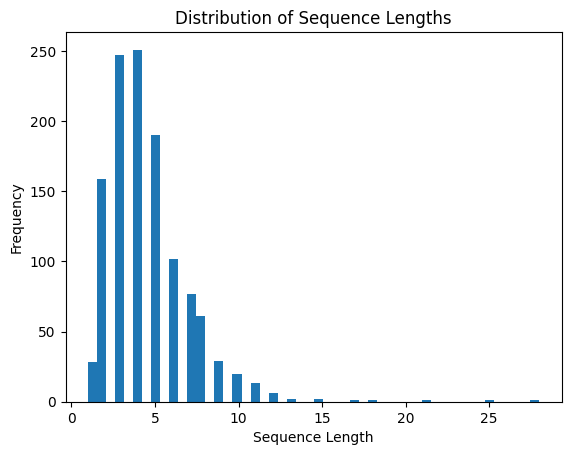

In [101]:
import matplotlib.pyplot as plt

# 기초 통계량
max_len = max(len(seq) for seq in x_train)
min_len = min(len(seq) for seq in x_train)
avg_len = sum(map(len, x_train)) / len(x_train)

print("Maximum sequence length:", max_len)
print("Minimum sequence length:", min_len)
print("Average sequence length:", avg_len)

# 분포 그래프
plt.hist([len(seq) for seq in x_train], bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

* 문장별 토큰이 가장 큰 것이 57개 입니다.

* 학습 입력을 위한 데이터 크기 맞추기
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

In [102]:
MAX_SEQUENCE_LENGTH = 28

In [103]:
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

y_train = train_df['type'].values
y_val = test_df['type'].values

#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

In [104]:
classifier_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(32, return_sequences=True),
    LSTM(16),
    Dense(8),
    Dense(4),
    Dense(1, activation='sigmoid')
])

In [106]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

x_train = tf.convert_to_tensor(x_train, dtype=tf.int32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)

classifier_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
classifier_model.fit(x_train, y_train, callbacks=[es], validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
30/30 [==============================] - 13s 105ms/step - loss: 0.6928 - acc: 0.5026 - val_loss: 0.6663 - val_acc: 1.0000
Epoch 2/10
30/30 [==============================] - 1s 35ms/step - loss: 0.6198 - acc: 0.6369 - val_loss: 0.3113 - val_acc: 0.9121
Epoch 3/10
30/30 [==============================] - 1s 31ms/step - loss: 0.1488 - acc: 0.9885 - val_loss: 0.3129 - val_acc: 0.9079
Epoch 4/10
30/30 [==============================] - 1s 30ms/step - loss: 0.0265 - acc: 0.9990 - val_loss: 0.2832 - val_acc: 0.9372
Epoch 5/10
30/30 [==============================] - 1s 30ms/step - loss: 0.0129 - acc: 0.9990 - val_loss: 0.3916 - val_acc: 0.9247
Epoch 6/10
30/30 [==============================] - 1s 31ms/step - loss: 0.0161 - acc: 0.9979 - val_loss: 0.4092 - val_acc: 0.9247
Epoch 7/10
30/30 [==============================] - 1s 30ms/step - loss: 0.0095 - acc: 0.9990 - val_loss: 0.3626 - val_acc: 0.9331
Epoch 8/10
30/30 [==============================] - 1s 31ms/step - loss: 0.0090 -

In [111]:
pred = classifier_model.predict(x_val)
pred = np.where(pred>=0.5, 1, 0)
pred = pred[:106]

print(accuracy_score(y_val, pred))

8/8 [==============================] - 0s 17ms/step


ValueError: ignored

### (2) FastText 모델 : 사전학습된 Word2Vec 모델을 사용

-  FastText 모델 학습을 위한 입력 포맷 2차원 리스트 형태 입니다.
  ```
  [['나', '는', '학생', '이다'], ['오늘', '은', '날씨', '가', '좋다']]
  ```

- Word2Vec계열의 FastText를 학습하는 이유
  - n-gram이 추가된 fasttext 모델은 유사한 단어에 대한 임베딩을 word2vec보다 잘 해결할 수 있으며, 오탈자 등에 대한 임베딩 처리가 가능하다.
  - 예) 체크카드, 쳌카드는 word2vec에서는 전혀 다른 단어이지만 fasttext는 character n-gram으로 비교적 같은 단어로 처리할 수 있다.
- 참고: https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText


#### 1) 데이터 준비
* 시작데이터 : clean_train_questions, clean_test_questions

* FastText를 위한 입력 데이터 구조 만들기

#### 2) FastText 모델 생성
* FastText 문법
    * FastText( input데이터,  min_count = , size= , window=  )
        * input데이터 : 학습에 사용할 문장으로 이루어진 리스트
        * min_count : 모델에 사용할 단어의 최소 빈도수. 이 값보다 적게 출현한 단어는 모델에 포함되지 않음. 기본값 = 5
        * size : 단어의 벡터 차원 지정. 기본값 = 100
        * window : 학습할 때 한 단어의 좌우 몇 개의 단어를 보고 예측을 할 것인지를 지정. 기본값 = 5
    * 참조 : https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText

In [ ]:
from gensim.models.fasttext import FastText
import gensim.models.word2vec



#### 3) train에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

### (3) 챗봇 구축
- input 질문
- intent classifier로 common와 faq 중 하나를 예측
- 예측된 intent에 속한 train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
- 코사인 유사도가 가장 높은 top-3개의 Q를 선택
- 선택한 Q에 맵핑된 답변 중 하나를 선택하고 실제 답변과 비교

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

* 예측을 위한 입력 형태로 변환

* 예측하기

* 질문에 대한 벡터 만들기
    * FestText 모델로 부터 벡터 만들기

* train의 질문 벡터들과 유사도 계산
    * FastText 로 만들 벡터들과 유사도 계산

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


#### 2) 함수로 생성하기

In [ ]:
def get_answer2(question):


    return

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

## 5.질문에 대한 답변 비교해보기

* **세부요구사항**
    * 세가지 챗봇을 생성해 보았습니다.
    * 질문을 입력하여 답변을 비교해 봅시다. 어떤 챗봇이 좀 더 정확한 답변을 하나요?
